In [1]:
### Requirements ###
# Windows 10 21H2
# Nvidia Triton 23.02-py3

# Docker Desktop 4.17.1
# 경로 'C:\Users\사용자_이름' 내 .wslconfig 파일 설정
# [wsl2]
# memory=2GB
# swap=1GB

In [2]:
### Terminal Run ###
# docker run --rm -it -p 8000:8000 -p 8001:8001 -p 8002:8002 
# -v D:/triton-inference-tutorial:/models 
# nvcr.io/nvidia/tritonserver:23.02-py3 
# tritonserver --model-repository=/models 
# --log-verbose 1 --strict-model-config=True

#### Terminal 확인 ####
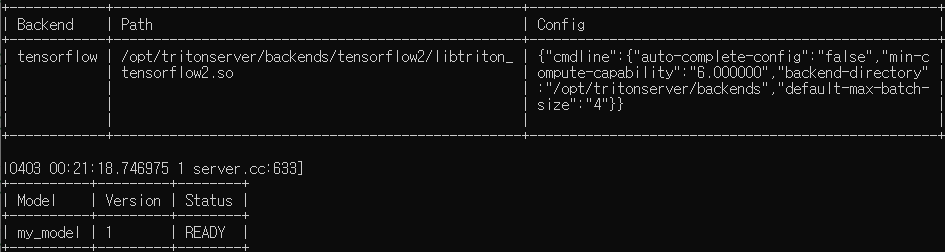

In [3]:
### Inference Run ###
import numpy as np
import tritonclient.grpc as grpc_client
from tritonclient.utils import np_to_triton_dtype
from time import time

In [4]:
# 샘플 입력 데이터 (ex. TLSTM)
# 1
input_data = np.array([[ 86.       ,   1.       ,   0.       ,  17.36     ,  63.       ,
        159.0441375, 100.       ,  76.       , 212.       ,  68.       ,
         60.       , 138.       ,  13.       ,   1.4      ,  16.       ,
         11.       ,  17.       ,   1.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   1.       ,   0.       ,
          1.       ,   0.       ,   0.       ,   1.       ,   1.       ,
          0.       ,   1.       ,   0.       ,   1.       ,   0.       ,
          0.       ,   1.       ,   1.       ,   0.       ,   1.       ,
          0.       ,   1.       ,   0.       ,   1.       ,   0.       ,
          1.       ,   0.       ,   0.       ,   0.       ,   1.       ,
          0.       ,   0.       ,   1.       ,   0.       ,   0.       ,
          0.       ,   1.       ,   0.       ,   0.       ],
       [ 88.       ,   1.       ,   0.       ,  17.01     ,  66.       ,
        110.       ,  60.       ,  87.       , 227.       , 131.       ,
         61.       , 140.       ,  12.8      ,   1.4      ,  28.       ,
         14.       ,  13.       ,   1.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   1.       ,   0.       ,
          1.       ,   0.       ,   0.       ,   1.       ,   1.       ,
          0.       ,   1.       ,   0.       ,   1.       ,   0.       ,
          0.       ,   1.       ,   1.       ,   0.       ,   1.       ,
          0.       ,   1.       ,   0.       ,   1.       ,   0.       ,
          1.       ,   0.       ,   0.       ,   0.       ,   1.       ,
          0.       ,   0.       ,   1.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   1.       ],
       [ 90.       ,   1.       ,   0.       ,  17.72     ,  81.       ,
        114.       ,  55.       ,  75.       , 215.       , 107.       ,
         45.       , 148.       ,  10.6      ,   1.6      ,  19.       ,
          8.       ,  12.       ,   1.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   1.       ,   0.       ,
          1.       ,   0.       ,   0.       ,   1.       ,   1.       ,
          0.       ,   1.       ,   0.       ,   1.       ,   0.       ,
          0.       ,   1.       ,   1.       ,   0.       ,   1.       ,
          0.       ,   1.       ,   0.       ,   1.       ,   0.       ,
          1.       ,   0.       ,   0.       ,   0.       ,   1.       ,
          0.       ,   0.       ,   1.       ,   0.       ,   0.       ,
          0.       ,   1.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ]]).astype('float32')

In [5]:
# 2
input_time = np.array([  0., 614., 951.,   0.,   0.]).astype('float32')
# 3
input_position = np.array(2).astype('int32')
# 1 batch
input_data = np.expand_dims(input_data, axis=0)
input_time = np.expand_dims(input_time, axis=0)
input_position = np.expand_dims(input_position, axis=0)

In [6]:
# 도커 grpc 통신
triton_client = grpc_client.InferenceServerClient(url='localhost:8001', verbose=True)

In [7]:
# 모델 및 버전 선택
model_name = 'my_model'
model_version = '1'

In [8]:
# 입력 데이터를 모델의 입력 형식으로 변환
input_dtype = np_to_triton_dtype(input_data.dtype)
input_shape = input_data.shape
input_tensor_data = grpc_client.InferInput('input_1', input_shape, input_dtype)
input_tensor_data.set_data_from_numpy(input_data)

input_dtype = np_to_triton_dtype(input_time.dtype)
input_shape = input_time.shape
input_tensor_time = grpc_client.InferInput('input_2', input_shape, input_dtype)
input_tensor_time.set_data_from_numpy(input_time)

input_dtype = np_to_triton_dtype(input_position.dtype)
input_shape = input_position.shape
input_tensor_position = grpc_client.InferInput('input_3', input_shape, input_dtype)
input_tensor_position.set_data_from_numpy(input_position)

In [9]:
# inference 요청
inputs = [input_tensor_data, input_tensor_time, input_tensor_position]
outputs = [grpc_client.InferRequestedOutput('output_1')]

In [10]:
# 초기 모델 로딩 및 추론
time_list = []
dummy_time = time()
response = triton_client.infer(model_name, inputs=inputs, outputs=outputs, model_version=model_version)
output_tensor = response.as_numpy('output_1')
print(f"Model inference dummy time: {time()-dummy_time:.3f} seconds ")
time_list.append(f"1번째 :{time()-dummy_time:.3f} seconds / 결과 : {output_tensor}")

infer, metadata ()
model_name: "my_model"
model_version: "1"
inputs {
  name: "input_1"
  datatype: "FP32"
  shape: 1
  shape: 5
  shape: 59
}
inputs {
  name: "input_2"
  datatype: "FP32"
  shape: 1
  shape: 5
}
inputs {
  name: "input_3"
  datatype: "INT32"
  shape: 1
}
outputs {
  name: "output_1"
}
raw_input_contents: "\000\000\254B\000\000\200?\000\000\000\000H\341\212A\000\000|BM\013\037C\000\000\310B\000\000\230B\000\000TC\000\000\210B\000\000pB\000\000\nC\000\000PA33\263?\000\000\200A\000\0000A\000\000\210A\000\000\200?\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\000\000\000\000\200?\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\000\000\000\000\200?\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\000\000\000\000\000\000\000\00

In [11]:
# 이후 추론(모델은 이미 초기화되었으므로 이 시점부터는 순수한 추론 시간만 측정)
for i in range(100): # 100회 테스트
    inference_time = time()
    response = triton_client.infer(model_name, inputs=inputs, outputs=outputs, model_version=model_version)
    # print(f"Model inference time: {time()-inference_time:.3f} seconds")
    output_tensor = response.as_numpy('output_1')
    time_list.append(f"{i+2}번째 :{time()-inference_time:.3f} seconds / 결과 : {output_tensor}")

infer, metadata ()
model_name: "my_model"
model_version: "1"
inputs {
  name: "input_1"
  datatype: "FP32"
  shape: 1
  shape: 5
  shape: 59
}
inputs {
  name: "input_2"
  datatype: "FP32"
  shape: 1
  shape: 5
}
inputs {
  name: "input_3"
  datatype: "INT32"
  shape: 1
}
outputs {
  name: "output_1"
}
raw_input_contents: "\000\000\254B\000\000\200?\000\000\000\000H\341\212A\000\000|BM\013\037C\000\000\310B\000\000\230B\000\000TC\000\000\210B\000\000pB\000\000\nC\000\000PA33\263?\000\000\200A\000\0000A\000\000\210A\000\000\200?\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\000\000\000\000\200?\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\000\000\000\000\200?\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\000\000\000\000\000\000\000\00

model_name: "my_model"
model_version: "1"
outputs {
  name: "output_1"
  datatype: "FP32"
  shape: 1
  shape: 1
}
raw_output_contents: "\220r\357<"

infer, metadata ()
model_name: "my_model"
model_version: "1"
inputs {
  name: "input_1"
  datatype: "FP32"
  shape: 1
  shape: 5
  shape: 59
}
inputs {
  name: "input_2"
  datatype: "FP32"
  shape: 1
  shape: 5
}
inputs {
  name: "input_3"
  datatype: "INT32"
  shape: 1
}
outputs {
  name: "output_1"
}
raw_input_contents: "\000\000\254B\000\000\200?\000\000\000\000H\341\212A\000\000|BM\013\037C\000\000\310B\000\000\230B\000\000TC\000\000\210B\000\000pB\000\000\nC\000\000PA33\263?\000\000\200A\000\0000A\000\000\210A\000\000\200?\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\000\000\000\000\200?\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\000\000\000\000\200?\000\000\200?\000\000\000\000\000\0

model_name: "my_model"
model_version: "1"
outputs {
  name: "output_1"
  datatype: "FP32"
  shape: 1
  shape: 1
}
raw_output_contents: "\220r\357<"

infer, metadata ()
model_name: "my_model"
model_version: "1"
inputs {
  name: "input_1"
  datatype: "FP32"
  shape: 1
  shape: 5
  shape: 59
}
inputs {
  name: "input_2"
  datatype: "FP32"
  shape: 1
  shape: 5
}
inputs {
  name: "input_3"
  datatype: "INT32"
  shape: 1
}
outputs {
  name: "output_1"
}
raw_input_contents: "\000\000\254B\000\000\200?\000\000\000\000H\341\212A\000\000|BM\013\037C\000\000\310B\000\000\230B\000\000TC\000\000\210B\000\000pB\000\000\nC\000\000PA33\263?\000\000\200A\000\0000A\000\000\210A\000\000\200?\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\000\000\000\000\200?\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\200?\000\000\000\000\000\000\000\000\000\000\200?\000\000\200?\000\000\000\000\000\0

In [12]:
# 간단한 모델이기에 로컬 cpu로도 오래걸리지 않는다
for record in time_list:
    print(record)

1번째 :0.009 seconds / 결과 : [[0.02922943]]
2번째 :0.004 seconds / 결과 : [[0.02922943]]
3번째 :0.004 seconds / 결과 : [[0.02922943]]
4번째 :0.003 seconds / 결과 : [[0.02922943]]
5번째 :0.003 seconds / 결과 : [[0.02922943]]
6번째 :0.003 seconds / 결과 : [[0.02922943]]
7번째 :0.003 seconds / 결과 : [[0.02922943]]
8번째 :0.003 seconds / 결과 : [[0.02922943]]
9번째 :0.003 seconds / 결과 : [[0.02922943]]
10번째 :0.003 seconds / 결과 : [[0.02922943]]
11번째 :0.003 seconds / 결과 : [[0.02922943]]
12번째 :0.003 seconds / 결과 : [[0.02922943]]
13번째 :0.003 seconds / 결과 : [[0.02922943]]
14번째 :0.003 seconds / 결과 : [[0.02922943]]
15번째 :0.003 seconds / 결과 : [[0.02922943]]
16번째 :0.003 seconds / 결과 : [[0.02922943]]
17번째 :0.003 seconds / 결과 : [[0.02922943]]
18번째 :0.003 seconds / 결과 : [[0.02922943]]
19번째 :0.003 seconds / 결과 : [[0.02922943]]
20번째 :0.003 seconds / 결과 : [[0.02922943]]
21번째 :0.003 seconds / 결과 : [[0.02922943]]
22번째 :0.003 seconds / 결과 : [[0.02922943]]
23번째 :0.003 seconds / 결과 : [[0.02922943]]
24번째 :0.003 seconds / 결과 : [[0.02922943]]
2

In [13]:
# 서버내 실험 & memory leakage 확인 필수 (cont'd)